In [19]:
# Importing required stuff.
import numpy as np
import matplotlib.pyplot as plt
import time
from numba import njit
from typing import Tuple

# Configurations and constants
N_GAMBLERS: int = 20_000
T_ROUNDS: int = 2_000
STARTING_BANKROLL: int = 100

In [20]:
# Numpy Simulation.
def run_numpy_sim(n: int, t: int, start_wealth: int) -> np.ndarray:
    # Generates outcomes(-1 or 1)
    outcomes = np.random.choice([-1, 1], size=(n, t))
    # Cumulative sum and start wealt
    start_col = np.full((n, 1), start_wealth)
    # Trajectory
    path = np.hstack([start_col, start_col+np.cumsum(outcomes, axis=1)])
    # Handle bankruptcy
    is_bankrupt = path <= 0
    # Finding if a gambler has ever been bankdrupt
    ever_bankrupt = np.maximum.accumulate(is_bankrupt, axis=1)
    # Apply mask
    path[ever_bankrupt] = 0
    return path

In [21]:
# Numba simulation
# Note that Numba will optimise the for loops.
@njit
def run_numba_sim(n: int, t: int, start_wealth: int) -> np.ndarray:
    paths = np.zeros((n, t+1))
    for i in range(n):
        current_wealth = float(start_wealth)
        paths[i, 0] = current_wealth
        for j in range(1, t+1):
            if current_wealth<=0:
                paths[i, j] = 0
                continue
            flip = 1 if np.random.random() > 0.5 else -1
            current_wealth += flip

            if current_wealth <= 0:
                current_wealth = 0
                
            paths[i, j] = current_wealth
    return paths

In [22]:
# Execution and benchmarking
print("Starting NumPy Simulation...")
start_time = time.time()
np_paths = run_numpy_sim(N_GAMBLERS, T_ROUNDS, STARTING_BANKROLL)
np_duration = time.time() - start_time
print(f"NumPy Time: {np_duration:.4f}s")

print("\nStarting Numba Simulation (including JIT compile time)...")
start_time = time.time()
nb_paths = run_numba_sim(N_GAMBLERS, T_ROUNDS, STARTING_BANKROLL)
nb_duration = time.time() - start_time
print(f"Numba Time: {nb_duration:.4f}s")

Starting NumPy Simulation...
NumPy Time: 0.9313s

Starting Numba Simulation (including JIT compile time)...
Numba Time: 0.8281s


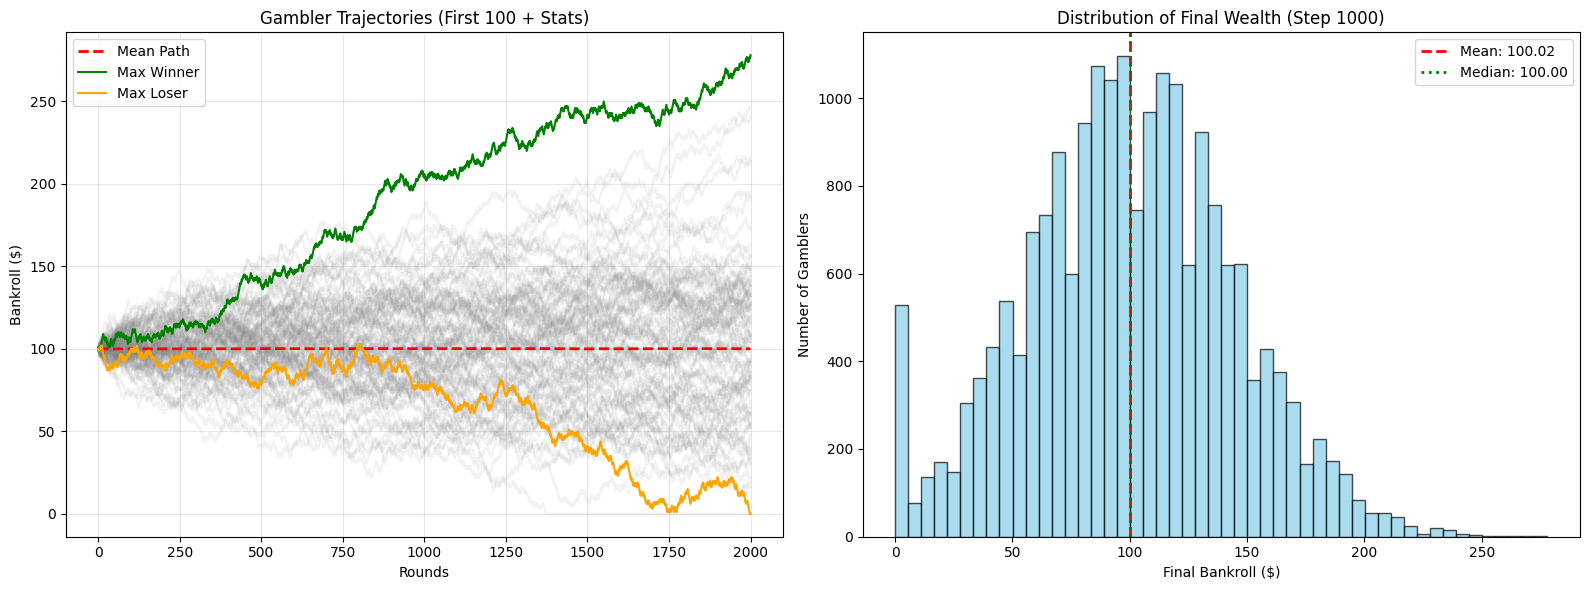

In [23]:
# Visualisation
def create_dashboard(paths: np.ndarray):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot 1: Spaghetti Plot
    time_steps = np.arange(T_ROUNDS + 1)
    
    # Plot first 100 paths
    for i in range(100):
        ax1.plot(time_steps, paths[i, :], color='gray', alpha=0.1)
    
    # Statistics for plotting
    mean_path = np.mean(paths, axis=0)
    final_wealths = paths[:, -1]
    max_winner_idx = np.argmax(final_wealths)
    max_loser_idx = np.argmin(final_wealths)
    
    ax1.plot(time_steps, mean_path, color='red', linestyle='--', linewidth=2, label='Mean Path')
    ax1.plot(time_steps, paths[max_winner_idx, :], color='green', linewidth=1.5, label='Max Winner')
    ax1.plot(time_steps, paths[max_loser_idx, :], color='orange', linewidth=1.5, label='Max Loser')
    
    ax1.set_title("Gambler Trajectories (First 100 + Stats)")
    ax1.set_xlabel("Rounds")
    ax1.set_ylabel("Bankroll ($)")
    ax1.legend()
    ax1.grid(alpha=0.3)

    # Plot 2: Final Distribution
    ax2.hist(final_wealths, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
    
    mean_val = np.mean(final_wealths)
    median_val = np.median(final_wealths)
    
    ax2.axvline(mean_val, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_val:.2f}')
    ax2.axvline(median_val, color='green', linestyle='dotted', linewidth=2, label=f'Median: {median_val:.2f}')
    
    ax2.set_title("Distribution of Final Wealth (Step 1000)")
    ax2.set_xlabel("Final Bankroll ($)")
    ax2.set_ylabel("Number of Gamblers")
    ax2.legend()

    plt.tight_layout()
    plt.show()

create_dashboard(np_paths)

**The Central Limit Theorem (CLT) and Variance**
Even though a single coin flip is a discrete "win or lose" event, the **Central Limit Theorem** states that the sum of a large number of independent random variables (our 1,000 flips) will tend toward a **Normal Distribution (Bell Curve)**. 

The "spread" we see in the histogram is a visualization of **Variance**. In a random walk, the standard deviation increases relative to the square root of time ($\sigma \sqrt{t}$). This explains why, despite the game being "fair" (expected return of 0), individual gamblers end up far apart. Some "luck into" a sequence of wins, while others suffer a sequence of losses.

**Observed skewness(impact of ruin)**
While the CLT suggests a perfect bell curve, our simulation introduces an **absorbing boundary** at $0$. This significantly alters the distribution in two ways:

1.  **The Spike at Zero:** There is a large concentration of gamblers at exactly $\$0$. These are the "ruined" players who would have potentially recovered in a theoretical model but are stopped in reality. This spike becomes larger as the number of rounds increases
2.  **Right Skewness:** The distribution becomes **Positively Skewed**. Because wealth cannot go below zero but has no upper limit, the "left tail" of the normal distribution is essentially cut off and piled up at zero. 
3.  **Survival Bias:** The mean of the final wealth will likely be slightly higher than the starting $\$100$ if we only look at survivors, but when including the zeros, the "average" reality is a brutal illustration of how variance eventually bankrupts players even in a "fair" game if they have finite capital.

**Why is Numba potentially faster?**
While NumPy is vectorized and uses C-level loops, it still has to create several large intermediate arrays (the `outcomes` matrix, the `is_bankrupt` mask, the `ever_bankrupt` mask). This consumes significant memory and involves multiple passes over the data.

**Numba (JIT)** compiles the Python code into machine code. It allows us to use `for` loops that run at C-speed. Because Numba processes the logic in a single pass (checking bankruptcy while summing), it avoids creating massive intermediate mask arrays, reducing memory overhead and CPU cache misses. Morover, Numba eliminates the Python interpeter overhead.